<a href="https://colab.research.google.com/github/angela-kralevska/COVID19_MK_project/blob/master/FineTuningBERT_Transformers_MoodyLyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the dataset Moody Lyrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

dataset_ml = pd.read_csv('drive/My Drive/MER_NLP/MoodyLyrics_complete.csv')
del dataset_ml['Unnamed: 0']

print(dataset_ml.shape)
dataset_ml.head()

(1968, 4)


,Artist,Title,Mood,Lyrics
0,.38 Special,Fantasy Girl,relaxed,"Lately, I'm learnin' That so many yearnings ar..."
1,.38 Special,Second Chance,happy,Since you've been gone I feel my life slipping...
2,3 Inches Of Blood,Trial Of Champions,angry,Enslaved by warlords from far away lands Force...
3,30 Seconds To Mars,Search And Destroy,angry,"Grab your gun, time to go to hell I'm no hero ..."
4,311,Lovesong,happy,Whenever I'm alone with you You make me feel l...


In [ ]:
filter = dataset_ml["Lyrics"] != ""
dataset_ml = dataset_ml[filter]

In [ ]:
dataset_ml = dataset_ml.dropna()
dataset_ml = dataset_ml.drop_duplicates(subset='Lyrics', keep="first")

In [ ]:
dataset_ml.describe()

,Artist,Title,Mood,Lyrics
count,1927,1927,1927,1927
unique,1376,1771,4,1927
top,The Beatles,Silent Night,relaxed,Rollin' down a long highway out through New Me...
freq,23,20,486,1


relaxed    486
happy      484
sad        480
angry      477
Name: Mood, dtype: int64


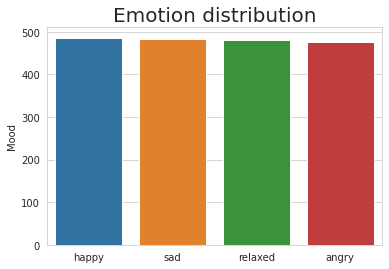

In [ ]:
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes()
import matplotlib.pyplot as plt

emotion_labels = ['happy', 'sad', 'relaxed', 'angry']
emotionDistribution = dataset_ml.Mood.value_counts()
print(emotionDistribution)
ax = sns.barplot(x=np.array(range(4)),y=emotionDistribution)
ax.set_title('Emotion distribution',fontsize=20)
ax.set_xticklabels(emotion_labels)
plt.show()

In [ ]:
!pip install langdetect

     |████████████████████████████████| 981 kB 12.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993241 sha256=17e589271016d976c311345508da8ab1cac483036dab9830899e40ce110f115a
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
import langdetect as ld
counter_english = 0
counter_spanish = 0
counter_another = 0

for index, row in dataset_ml.iterrows():
  try:
    if ld.detect(row['Lyrics'])=='en':
      counter_english += 1
    elif ld.detect(row['Lyrics'])=='es':
      counter_spanish += 1
    else:
      counter_another += 1
  except:
    print(row['Lyrics'])

In [ ]:
for index, row in dataset_ml.iterrows():
  if ld.detect(row['Lyrics'])!='en':
    dataset_ml = dataset_ml.drop(index=index)

In [ ]:
labels = dataset_ml['Mood']
unique_labels = labels.unique()
unique_labels

array(['relaxed', 'happy', 'angry', 'sad'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

dataset_ml['Mood'] = dataset_ml['Mood'].replace({'relaxed':0, 'happy':1, 'angry':2, 'sad':3})
X = dataset_ml['Lyrics']
y = dataset_ml['Mood']
X_copy = dataset_ml['Lyrics']
y_copy = dataset_ml['Mood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(dataset_ml['Lyrics'])

In [ ]:
num_words = len(tokenizer.word_index)
tokens = tokenizer.texts_to_sequences(dataset_ml['Lyrics'])
num_t = [len(t) for t in tokens]
num_t = np.array(num_t)
avg = np.mean(num_t)
avg

403.78426966292136

# Setting up the environment for HF transformers

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5 MB 12.5 MB/s 
     |████████████████████████████████| 895 kB 40.6 MB/s 
     |████████████████████████████████| 3.3 MB 46.0 MB/s 


In [ ]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf
 
        tf.random.set_seed(seed)
 
set_seed(1)

In [ ]:
# the model we gonna train, base uncased BERT
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 400

In [ ]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [ ]:
from sklearn.model_selection import train_test_split

X = list(X)
y = list(y)
(train_texts, valid_texts, train_labels, valid_labels) = train_test_split(X, y, test_size=0.25)

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [ ]:
class MoodyLyricsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = MoodyLyricsDataset(train_encodings, train_labels)
valid_dataset = MoodyLyricsDataset(valid_encodings, valid_labels)

In [ ]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4).to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  prec = precision_score(labels, preds, average='weighted')
  rec = recall_score(labels, preds, average='weighted')
  return {
      'accuracy': acc,
      'precision': prec,
      'recall': rec
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=50,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
# train the model
trainer.train()

***** Running training *****
  Num examples = 1335
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 252


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall
50,1.406100,1.316988,0.402247,0.391430,0.402247
100,1.201200,1.094545,0.588764,0.600853,0.588764
150,0.962500,0.959234,0.651685,0.674493,0.651685
200,0.612200,0.466257,0.849438,0.852044,0.849438
250,0.407900,0.399192,0.849438,0.862004,0.849438


***** Running Evaluation *****
  Num examples = 445
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 445
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 445
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-150
Configuration saved in ./results/checkpoint-150/config.json
Model weights saved in ./results/checkpoint-150/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 445
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Runni

TrainOutput(global_step=252, training_loss=0.9145779174471659, metrics={'train_runtime': 727.3352, 'train_samples_per_second': 5.506, 'train_steps_per_second': 0.346, 'total_flos': 1052372857392000.0, 'train_loss': 0.9145779174471659, 'epoch': 3.0})

In [ ]:
# evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 445
  Batch size = 20


{'epoch': 3.0,
 'eval_accuracy': 0.849438202247191,
 'eval_loss': 0.39919203519821167,
 'eval_precision': 0.8620038778102006,
 'eval_recall': 0.849438202247191,
 'eval_runtime': 24.1442,
 'eval_samples_per_second': 18.431,
 'eval_steps_per_second': 0.953}

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/config.json
Model weights saved in drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/pytorch_model.bin
tokenizer config file saved in drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/tokenizer_config.json
Special tokens file saved in drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/special_tokens_map.json


('drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/tokenizer_config.json',
 'drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/special_tokens_map.json',
 'drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/vocab.txt',
 'drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/added_tokens.json',
 'drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/tokenizer.json')

In [ ]:
# reload our model/tokenizer. Optional, only usable when in Python files instead of notebooks
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=4).to("cuda")
tokenizer = BertTokenizerFast.from_pretrained(model_path)

loading configuration file drive/My Drive/MER_NLP/moodylyrics-bert-base-uncased/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file dr

In [ ]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    if probs.argmax().item()==0:
      label='relaxed'
    elif probs.argmax().item()==1:
      label='happy'
    elif probs.argmax().item()==2:
      label='angry'
    else:
      label='sad'
    return label

In [ ]:
# Example #1
text = """
Because I'm happy
Clap along if you feel like a room without a roof
Because I'm happy
Clap along if you feel like happiness is the truth
Because I'm happy
Clap along if you know what happiness is to you
Because I'm happy
Clap along if you feel like that's what you wanna do
"""
print(get_prediction(text))

happy


In [ ]:
# Example #2
text = """
Does it get your blood boiling, does it make you see red?
Do you wanna destroy it, does it get in your head?
'Cause it gets my blood boiling and I'm coming unglued
It would hit you like poison if you knew what I knew
You would be angry took
Calm down girl, why you so mad?
Why's your heart gone
It's all good girl, why you upset?
Guess they have forgotten what they did
And does it get your blood boiling and does it make you see red?
And do you wanna destroy it, does it get in your head?
'Cause it gets my blood boiling and I'm coming unglued
It would hit you like poison if you knew what I knew
You would be angry, you would be angry
You would be angry, you would be angry too
"""
print(get_prediction(text))

angry


In [ ]:
# Example #3
text = """
I get a good feeling, yeah
Oh, sometimes I get a good feeling, yeah
Get a feeling that I
Never, never, never, never had before, oh, no
I get a good feeling, yeah
Oh, sometimes I get a good feeling, yeah
Get a feeling that I
Never, never, never, never had before, oh, no
I get a good feeling, yeah
Just wanna tell ya right now that I
I really do believe it
"""
print(get_prediction(text))

relaxed


In [ ]:
# Example #4
text = """
Beneath the stains of time
The feelings disappear
You are someone else
I'm still right here
What have I become?
My sweetest friend
Everyone I know goes away
In the end
And you could have it all
My empire of dirt
I will let you down
I will make you hurt
If I could start again
A million miles away
I would keep myself
I would find a way
"""
print(get_prediction(text))

sad


# Model evaluation on Deezer strong balanced dataset

In [ ]:
dataset_deezer = pd.read_csv('drive/My Drive/MER_NLP/deezer_strong_balanced.csv')
del dataset_deezer['Unnamed: 0']

print(dataset_deezer.shape)
dataset_deezer.head()

(2760, 9)


,dzr_sng_id,MSD_sng_id,MSD_track_id,valence,arousal,artist_name,track_name,Lyrics,strong_mood
0,534268,SODNNXL12A58A7B9BC,TRUDSEY128F425AC3C,1.071901,0.846830,Marilyn Horne,All Through the Night,I want a woman like Marilyn Monroe The kind of...,happy
1,534847,SOVMVFH12AB0184F26,TRFBNQX128F92E3A87,0.682591,0.754644,Daughtry,Crashed,"Well, I was moving at the speed of sound Head-...",happy
2,535204,SOXOFZV12A8AE473FB,TRQGUZM128F425B7F6,1.178325,1.183311,The Hoosiers,Worried About Ray,"Truth be told, the truth be told I'm worried w...",happy
3,536164,SOHEUAX12AB018744C,TRRKNMB12903CC6B7E,1.071901,0.846830,Tina Arena,I Want To Know What Love Is,Gotta take a little time A little time to thin...,happy
4,538694,SOEDNXV12A8AE47B16,TRFXWUO128F425EAB3,1.071901,0.846830,Westlife,I'm Already There,He called her on the road From a lonely cold h...,happy


In [ ]:
X = dataset_deezer['Lyrics']

In [ ]:
list_of_predictions = []
for el in X:
  prediction = get_prediction(el)
  list_of_predictions.append(prediction)

In [ ]:
from sklearn.metrics import confusion_matrix

y = dataset_deezer['strong_mood']
cm = confusion_matrix(y, list_of_predictions, labels=["happy", "sad", "relaxed", "angry"])

In [ ]:
cm

array([[ 75, 297, 205, 113],
       [ 32, 415, 123, 120],
       [ 47, 357, 200,  86],
       [ 18, 399,  79, 194]])

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix 
import itertools 
import matplotlib.pyplot as plt
import numpy 

def confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.rcParams["figure.figsize"] = (10,10)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_cnf(true_y,pred, labels):

    cnf_matrix=sklearn.metrics.confusion_matrix(true_y, pred, labels)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.figure()
    a=confusion_matrix(cnf_matrix, classes=labels,title='Confusion matrix')

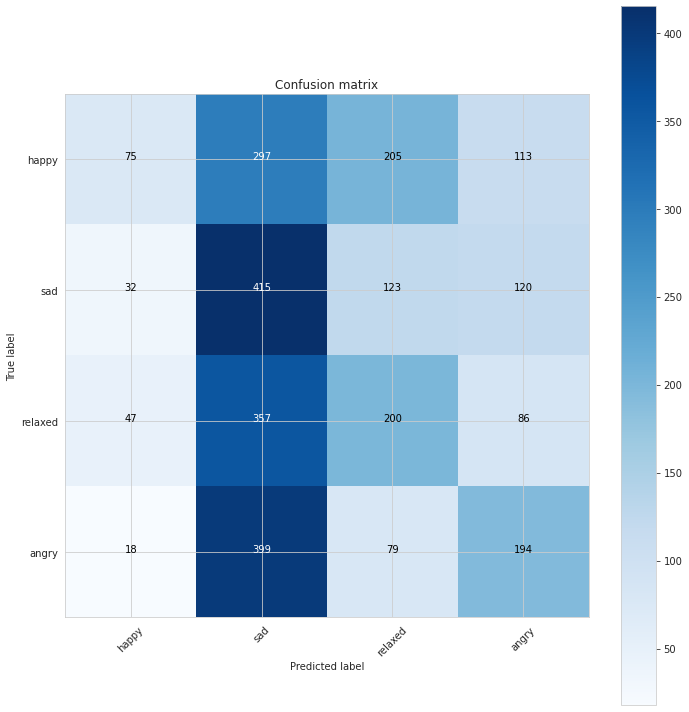

In [ ]:
plot_cnf(y, list_of_predictions, ["happy", "sad", "relaxed", "angry"])

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

y_true = np.array(y)
y_pred = np.array(list_of_predictions)
precision_recall_fscore_support(y_true, y_pred, average='weighted')

(0.3566002480588474, 0.32028985507246377, 0.29739008269376066, None)

In [ ]:
precision_recall_fscore_support(y_true, y_pred, average=None, labels=["happy", "sad", "relaxed", "angry"])

(array([0.43604651, 0.28269755, 0.32948929, 0.37816764]),
 array([0.10869565, 0.60144928, 0.28985507, 0.28115942]),
 array([0.17401392, 0.38461538, 0.30840401, 0.32252702]),
 array([690, 690, 690, 690]))